# Lasso(L1 Regularization) Regression

## References

## Theory

## Generate Data

In [1]:
import pandas as pd 
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns

from matplotlib import animation
from IPython import display

from utility import regression_plot, regression_animation

In [2]:
def add_axis_for_bias(X_i):
    m, n = X_i.shape
    if False in (X_i[:,0] == 1):        
        return np.c_[np.ones(m) , X_i]
    else:
        return X_i

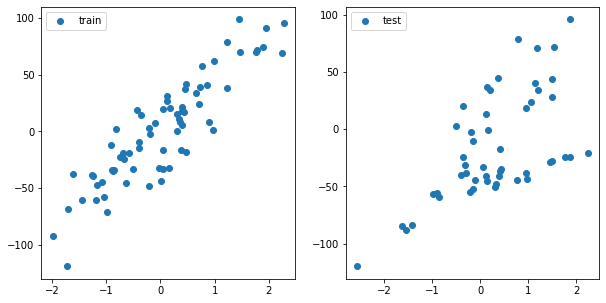

In [3]:
sample_size = 100
train_size = 0.7 #70%

X, y = make_regression(n_samples=sample_size, n_features=1, noise=20, random_state=0)
y = y.reshape(-1, 1)

np.random.seed(10)
random_idxs = np.random.permutation(np.arange(0, sample_size))[: int(np.ceil(sample_size * train_size))]
                                
X_train, y_train = X[random_idxs], y[random_idxs]
X_test, y_test = np.delete(X, random_idxs).reshape(-1, 1), np.delete(y, random_idxs).reshape(-1, 1)

### introduce bias in test data
bias = -50

X_r, y_r = make_regression(n_samples=20, n_features=1, noise=5, bias=bias, random_state=0)
X_test, y_test = np.r_[X_test, X_r], np.r_[y_test, y_r.reshape(-1, 1)]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(X_train, y_train, 'o', label='train')
ax[0].legend()
ax[1].plot(X_test, y_test, 'o', label='test')
ax[1].legend()
plt.show()

## Lasso with BGD

### Loss Function 

\begin{align}
    J(\theta) &= \frac{1}{2m}[{\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}{\theta_j}}]
\end{align}

In [4]:
def calculate_cost(y_pred, y, penalty, theta):
    m = y.shape[0]
    return ((np.square(y_pred - y)).sum() / (2 * m)) + ( penalty * theta.sum()/ (2 * m)) 

### Derivative/ Gradient


\begin{align}
    \frac{\partial{J(\theta)}}{\partial{\theta}} &= \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x^{(i)}} + \frac{\lambda}{2m}
\end{align}

In [5]:
def derivative(X, y, y_pred, penalty):
    m, n = X.shape
    return ((( y_pred - y ) * X ).sum(axis = 0) / m) + (penalty / (2 * m))

### Algorithm

\begin{align}
    \text{repeat until convergence \{}\\
    \theta_0 &:= \theta_0 - \alpha \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.x_0^{(i)}\\
    \theta_j &:= \theta_j - \alpha [ \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}} + \frac{\lambda}{2m} ]\\
    \text{\} j = 1,2,3,...,n}
\end{align} 

In [6]:
def predict(X, theta):
    format_X = add_axis_for_bias(X)
        
    if format_X.shape[1] == theta.shape[0]:
        y_pred = format_X @ theta # (m,1) = (m,n) * (n,1)
        return y_pred
    elif format_X.shape[1] == theta.shape[1]:
        y_pred = format_X @ theta.T # (m,1) = (m,n) * (n,1)
        return y_pred
    else:
        raise ValueError("Shape is not proper.")

In [7]:
def lasso_regression_bgd(X, y, verbose=True, theta_precision = 0.001, alpha = 0.01,
                         iterations = 10000, penalty=1.0):
    X = add_axis_for_bias(X)
    
    # number of features+1 because of theta_0
    m, n = X.shape

    theta_history = []
    cost_history = []

    theta = np.random.rand(1,n) * theta_precision

    for iteration in range(iterations):
        
        theta_history.append(theta[0])
        
        # calculate y_pred 
        y_pred = predict(X, theta)        
        
        # simultaneous operation     
        gradient = derivative(X, y, y_pred, penalty)
        theta = theta - (alpha *  gradient)

        if np.isnan(np.sum(theta)) or np.isinf(np.sum(theta)):
            print(f"breaking at iteration {iteration}. found inf or nan.")
            break

        # calculate cost to put in history
        cost = calculate_cost(predict(X, theta), y, penalty, theta)
        cost_history.append(cost)
        
    return theta, np.array(theta_history), np.array(cost_history)

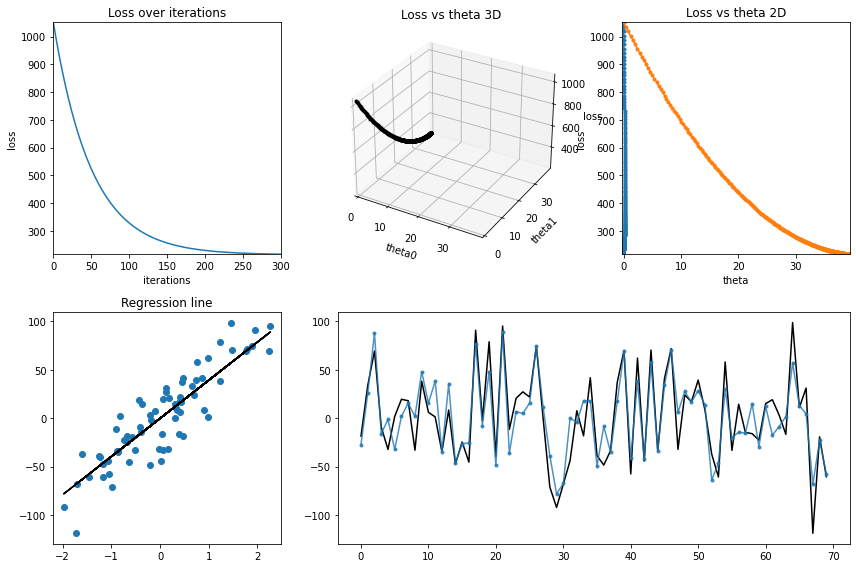

In [8]:
iterations = 300
learning_rate = 0.01
penalty = 0

theta, theta_history, cost_history = lasso_regression_bgd(X_train, y_train, verbose=True, theta_precision = 0.001,
                                                          alpha = learning_rate, iterations = iterations, penalty=penalty)

# regression_animation(X_train, y_train, cost_history, theta_history, iterations, interval=10)

regression_plot(X_train, y_train, cost_history, theta_history, iterations);

## Lasso with SGD

In [9]:
def lasso_regression_sgd(X, y, verbose=True, theta_precision = 0.001, batch_size=30, alpha = 0.01,
                         iterations = 10000, penalty=1.0):
    X = add_axis_for_bias(X)
    
    # number of features+1 because of theta_0
    m, n = X.shape

    theta_history = []
    cost_history = []

    theta = np.random.rand(1,n) * theta_precision
    
    for iteration in range(iterations):
        # calcualted theta in history
        theta_history.append(theta[0])

        # creating indices for batches
        indices = np.random.randint(0, m, size=batch_size)

        # creating batch for this iteration
        X_batch = np.take(X, indices,axis=0)
        y_batch = np.take(y, indices,axis=0)

        # calculate y_pred
        y_pred = predict(X_batch, theta)
        
        # simultaneous operation
        gradient = derivative(X_batch, y_batch, y_pred, penalty)
        theta = theta - (alpha *  gradient)
        
        if np.isnan(np.sum(theta)) or np.isinf(np.sum(theta)):
            print(f"breaking at iteration {iteration}. found inf or nan.")
            break
            
        # calculate cost to put in history
        cost = calculate_cost(predict(X_batch, theta), y_batch, penalty, theta)
        cost_history.append(cost)

    return theta, np.array(theta_history), np.array(cost_history)

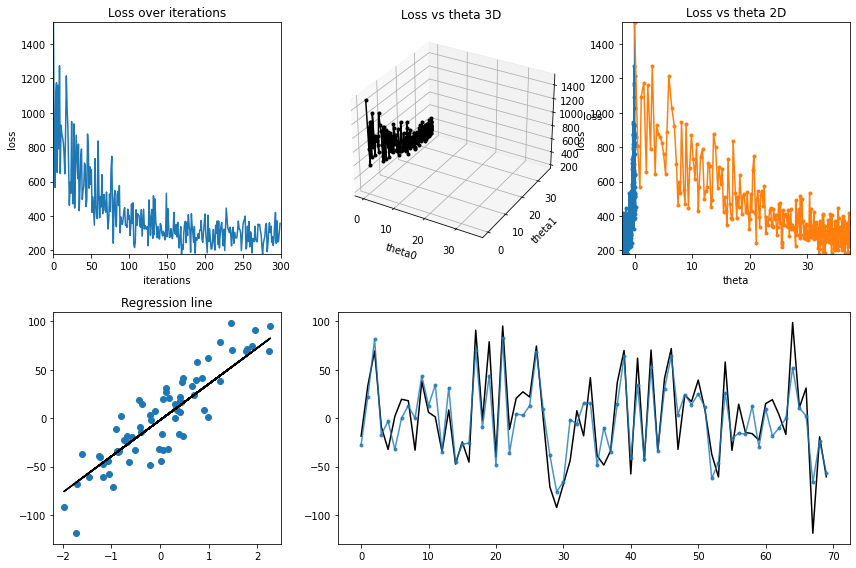

In [10]:
iterations = 300
learning_rate = 0.01
penalty = 100
theta, theta_history, cost_history = lasso_regression_sgd(X_train, y_train, verbose=True, theta_precision = 0.001, 
                                                           alpha = learning_rate ,iterations = iterations, batch_size=30,
                                                           penalty=penalty)

# regression_animation(X_train, y_train, cost_history,theta_history, iterations, interval=10)

regression_plot(X_train, y_train, cost_history,theta_history, iterations);